
# <span style="color:rgb(213,80,0)">Tutorial 7 - A Simple P4D Simulation</span>
## Introduction

In this tutorial, we will use a simple P4D simulation to explore the effects of battery cell architecture. After completing this tutorial, you should have a working knowledge of:

-  How to setup and run a P4D simulation of a single cell in BattMo
-  Advanced usage of combining model descriptions from multiple sources
## Construct the Model from Different Sources

Let's say that you parameterize some cell materials and put that data in a JSON file. Then you get some description of your cell geometry, and you put that data in another JSON file. Now you want to combine those descriptions into a single model and simulate it using some pre-defined contol protocol and simulation settings in other files. How can we combine those easily, without having to do any recoding?


To do that, we can simply make use of the mergeJsonStructs function in **BattMo**.


First, let’s define our cell materials. We have provided a JSON file that contains material properties for a NMC and Graphite active materials, which we can parse as a **BattMo** structure:


In [1]:
% parse material definitions as a BattMo structure
jsonfilename = 'ParameterData/BatteryCellParameters/LithiumIonBatteryCell/lithium_ion_battery_nmc_graphite.json';
jsonstruct_material = parseBattmoJson(jsonfilename);


Next, we have defined the cell geometry properties in a separate JSON file that we can also parse into **BattMo**:


In [2]:
% parse cell geometry specifications as a BattMo structure
jsonfilename = 'Examples/jsondatafiles/geometry3d.json';
jsonstruct_geometry = parseBattmoJson(jsonfilename);


Let's have a closer look at the cell geometry specification.


In [3]:
disp(jsonstruct_geometry.Geometry)

      case: '3D-demo'
     width: 0.0100
    height: 0.0200
        Nw: 10
        Nh: 10


Here we can see that the width and height dimensions of the cell are defined, along with the number of discretizations in each direction, and a case description. The case sets the type of simulation to be performed. Here it is set to '3D-demo', to BattMo knows to setp a P4D mesh.


We can take the same approach for the remaining parameters, as shown below, for the control protocol, simulation settings, and output settings:


In [4]:
% parse remaining parameters as BattMo structures

% control protocol
jsonfilename = fullfile('Examples', 'jsondatafiles', 'cc_discharge_control.json');
jsonstruct_control = parseBattmoJson(jsonfilename);

% simulation settings
jsonfilename = fullfile('Examples', 'jsondatafiles', 'simulation_parameters.json');
jsonstruct_simparams = parseBattmoJson(jsonfilename);

% output settings
jsonfilename = fullfile('Examples', 'jsondatafiles', 'extra_output.json');
jsonstruct_output = parseBattmoJson(jsonfilename);


Now, we can merge these parameter definitions into a single parameter set and run the simulation:


In [5]:
% combine the parameter structures from the different sources into a single
% BattMo structure
jsonstruct = mergeJsonStructs({jsonstruct_geometry , ...
                            jsonstruct_material , ...
                            jsonstruct_control  , ...
                            jsonstruct_simparams, ...
                            jsonstruct_output   , ...
                           });

parameter include_current_collectors is assigned twice with different values. we use the value from first jsonstruct.

In [6]:
% we store the output as a cell array so we can compare results across
% different simulation runs in this tutorial; here we instantiate an empty
% cell array
output = cell(2,1);

% run the simulation
output{1} = runBatteryJson(jsonstruct);

Solving timestep 01/45:                      -> 4 Seconds, 218 Milliseconds
Solving timestep 02/45: 4 Seconds, 218 Milliseconds -> 8 Seconds, 437 Milliseconds
Solving timestep 03/45: 8 Seconds, 437 Milliseconds -> 16 Seconds, 875 Milliseconds
Solving timestep 04/45: 16 Seconds, 875 Milliseconds -> 33 Seconds, 750 Milliseconds
Solving timestep 05/45: 33 Seconds, 750 Milliseconds -> 67 Seconds, 500 Milliseconds
Solving timestep 06/45: 67 Seconds, 500 Milliseconds -> 135 Seconds
Solving timestep 07/45: 135 Seconds          -> 270 Seconds
Solving timestep 08/45: 270 Seconds          -> 405 Seconds
Solving timestep 09/45: 405 Seconds          -> 540 Seconds
Solving timestep 10/45: 540 Seconds          -> 675 Seconds
Solving timestep 11/45: 675 Seconds          -> 810 Seconds
Solving timestep 12/45: 810 Seconds          -> 945 Seconds
Solving timestep 13/45: 945 Seconds          -> 1080 Seconds
Solving timestep 14/45: 1080 Seconds         -> 1215 Seconds
Solving timestep 15/45: 1215 Seconds 

## Visualize the Results

We plot the model using [plotBatteryMesh](https://github.com/BattMoTeam/BattMo/blob/dev/Utilities/Visualization/plotBatteryMesh.m) (note that the different axis are scaled differently)



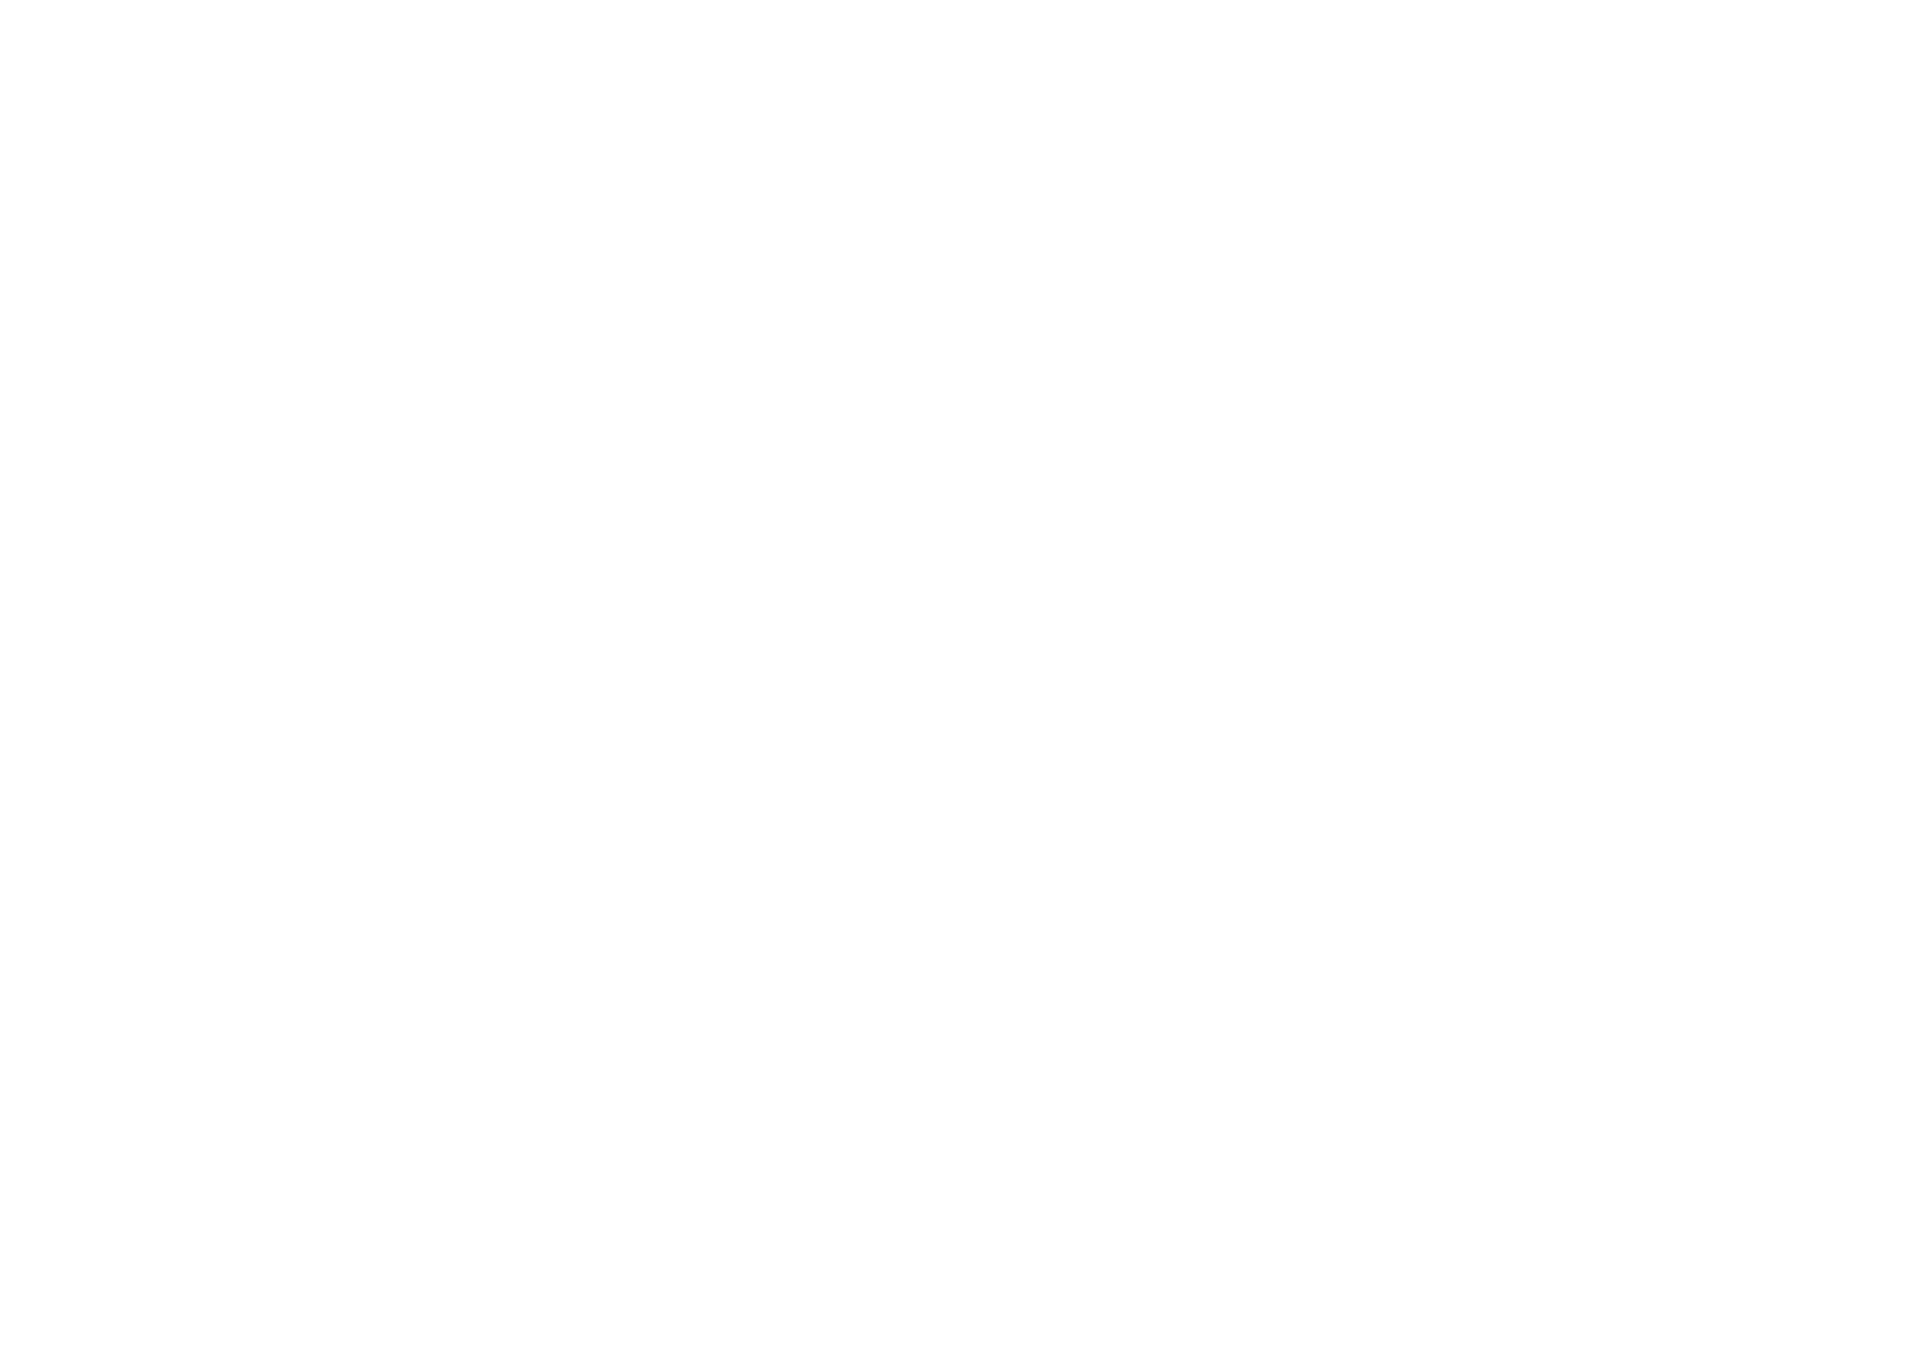

In [7]:
% create a shorthand variable for the model
model = output{1}.model;

% use the plotBatteryMesh function to show the grid
plotBatteryMesh(model)

% make the axis tight and set the camera viewing angle
axis tight
view(45,45)


We find a extensive set of plotting functions in [MRST](https://www.sintef.no/Projectweb/MRST/). You may be interested to have a look at the [Visualization Tutorial](https://www.sintef.no/projectweb/mrst/documentation/tutorials/visualization-tutorial/). Let us use the [plotGrid](https://github.com/SINTEF-AppliedCompSci/MRST/blob/main/core/plotting/plotGrid.m) and [plotCellData](https://github.com/SINTEF-AppliedCompSci/MRST/blob/main/core/plotting/plotCellData.m) to plot the surface particle concentrations in both electrode at a given time step.



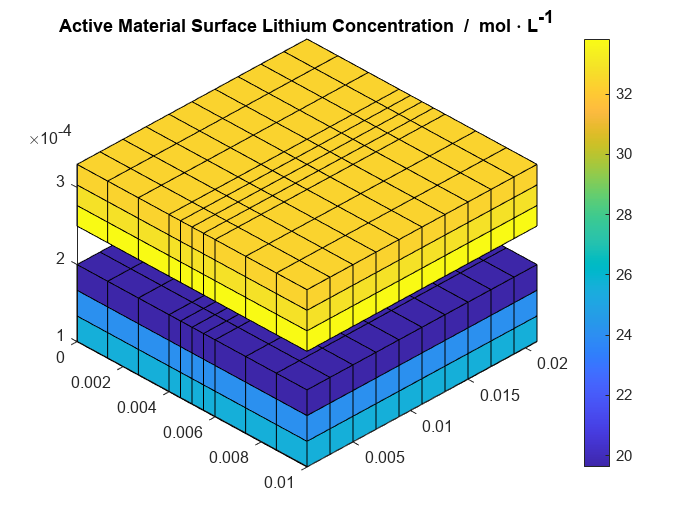

In [8]:
% set the timestep we want to visualize
timestep = 20;

% get the state of the simulation at the given timestep
state = output{1}.states{timestep};

% create a new figure
figure()

% plot the surface concentration of lithium in the negative electrode active material
plotCellData(model.NegativeElectrode.Coating.G, state.NegativeElectrode.Coating.ActiveMaterial.SolidDiffusion.cSurface/(mol/litre))

% plot the surface concentration of lithium in the positive electrode active material
plotCellData(model.PositiveElectrode.Coating.G, state.PositiveElectrode.Coating.ActiveMaterial.SolidDiffusion.cSurface/(mol/litre))

% add a colorbar
colorbar()

% make the axis tight and set the camera viewing angle
axis tight
view(45,45)

% add plot annotations
title('Active Material Surface Lithium Concentration  /  mol \cdot L^{-1}');

## Compare with a P2D Simulation

In [9]:
% change the setup of the model to consider a P2D case
jsonstruct.Geometry.case = '1D';
jsonstruct.Geometry.faceArea = jsonstruct.Geometry.width * jsonstruct.Geometry.height;

% change the rate
jsonstruct.Control.CRate = 1;

% update the total time of the simulation
jsonstruct.TimeStepping.totalTime = (1./jsonstruct.Control.CRate) .* 3600 .* 1.1;

% run the simulation
output{2} = runBatteryJson(jsonstruct);

Solving timestep 01/45:                     -> 3 Seconds, 93 Milliseconds
Solving timestep 02/45: 3 Seconds, 93 Milliseconds -> 6 Seconds, 187 Milliseconds
Solving timestep 03/45: 6 Seconds, 187 Milliseconds -> 12 Seconds, 375 Milliseconds
Solving timestep 04/45: 12 Seconds, 375 Milliseconds -> 24 Seconds, 750 Milliseconds
Solving timestep 05/45: 24 Seconds, 750 Milliseconds -> 49 Seconds, 500 Milliseconds
Solving timestep 06/45: 49 Seconds, 500 Milliseconds -> 99 Seconds
Solving timestep 07/45: 99 Seconds          -> 198 Seconds
Solving timestep 08/45: 198 Seconds         -> 297 Seconds
Solving timestep 09/45: 297 Seconds         -> 396 Seconds
Solving timestep 10/45: 396 Seconds         -> 495 Seconds
Solving timestep 11/45: 495 Seconds         -> 594 Seconds
Solving timestep 12/45: 594 Seconds         -> 693 Seconds
Solving timestep 13/45: 693 Seconds         -> 792 Seconds
Solving timestep 14/45: 792 Seconds         -> 891 Seconds
Solving timestep 15/45: 891 Seconds         -> 990 


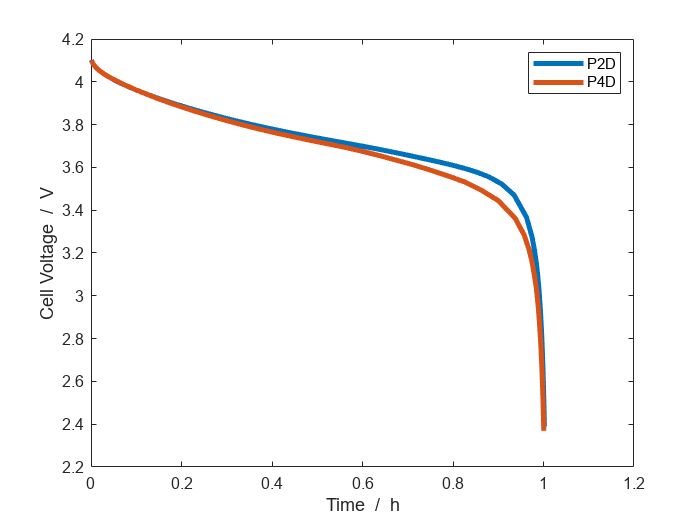

In [10]:

states_P2D = output{2}.states;
time_P2D = cellfun(@(state) state.time, states_P2D);
voltage_P2D = cellfun(@(state) state.('Control').E, states_P2D);

states_P4D = output{1}.states;
time_P4D = cellfun(@(state) state.time, states_P4D);
voltage_P4D = cellfun(@(state) state.('Control').E, states_P4D);

figure();
plot((time_P2D/hour), voltage_P2D, '-', 'linewidth', 3)
hold on
plot((time_P4D/hour), voltage_P4D, '-', 'linewidth', 3)
xlabel('Time  /  h')
ylabel('Cell Voltage  /  V')
legend('P2D', 'P4D')

## Summary

In this tutorial, we learned how to create a simple P4D simulation in BattMo. First, we explored how to combine parameter sets coming from a handful of different files into a single coherent BattMo model description. Then we had a closer look into the Geometry description to see how BattMo knows how to setup a P4D or P2D type model. After running the P4D simulation, we learned how to visualize simulation results on a 3D grid. For comparison, we ran the same model in a P2D configuration and plotted the discharge curves together. This showed that the results can diverge somewhat due to the effects of the tabs and non-ideal transport in the electrode plane. These results show that P4D models can yield important insight that may be lost in the averaged approach of P2D models.

